# Hotel Booking Cancellation Prediction

In [17]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

## Load and Describe Data

In [2]:
df = pd.read_csv('hotel_booking.csv')

In [3]:
df.isna().sum()

hotel                            0
is_canceled                      0
lead_time                        0
arrival_date_year                0
arrival_date_month               0
arrival_date_day_of_month        0
stays_in_weekend_nights          0
stays_in_week_nights             0
adults                           0
children                         4
babies                           0
meal                             0
country                        488
distribution_channel             0
previous_cancellations           0
reserved_room_type               0
booking_changes                  0
deposit_type                     0
required_car_parking_spaces      0
dtype: int64

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,booking_changes,required_car_parking_spaces
count,83544.000000,83544.000000,83544.000000,83544.000000,83544.000000,83544.000000,83544.000000,83540.000000,83544.000000,83544.000000,83544.000000,83544.000000
mean,0.279769,78.287034,2016.217514,15.804331,1.012125,2.636706,1.883690,0.143428,0.011216,0.030487,0.273820,0.086697
std,0.448888,84.313726,0.684256,8.843972,1.033990,2.060249,0.630405,0.463042,0.115707,0.363444,0.735082,0.285321
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,11.000000,2016.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.000000,2016.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,122.000000,2017.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,737.000000,2017.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,21.000000,8.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83544 entries, 0 to 119389
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        83544 non-null  object 
 1   is_canceled                  83544 non-null  int64  
 2   lead_time                    83544 non-null  int64  
 3   arrival_date_year            83544 non-null  int64  
 4   arrival_date_month           83544 non-null  object 
 5   arrival_date_day_of_month    83544 non-null  int64  
 6   stays_in_weekend_nights      83544 non-null  int64  
 7   stays_in_week_nights         83544 non-null  int64  
 8   adults                       83544 non-null  int64  
 9   children                     83540 non-null  float64
 10  babies                       83544 non-null  int64  
 11  meal                         83544 non-null  object 
 12  country                      83098 non-null  object 
 13  distribution_ch

## Data Pre-Processing

In [7]:
def clean(data):
    
    data['country'].fillna(data['country'].mode()[0], inplace = True)
    data['children'].fillna(data['children'].mean(), inplace = True)
    data["children"]=data["children"].astype(int)
    
    data["arrival_date_month"].replace({'July':"7", 'August':"8",
                                      'September':"9", 'October':"10", 
                                      'November':"11", 'December':"12", 
                                      'January':"1", 'February':"2", 
                                      'March':"3", 'April':"4",
                                      'May':"5", 'June':"6"}, inplace=True)
    
    
    

    data["arrival_date_month"]=data["arrival_date_month"].astype(int)
 
    return data

In [8]:
def encode_cat(data):
    data["hotel"].replace({'Resort Hotel':0, 'City Hotel':1}, inplace=True)
    
    listCountry=data["country"].unique()
    for i in range(len(listCountry)):
        data["country"].replace(listCountry[i],i,inplace=True)
        
        
        
        
    onehots =pd.get_dummies(data["meal"], dtype=float)
    data = data.join(onehots)
    data.drop("meal", axis='columns', inplace=True)
    
    
    onehots =pd.get_dummies(data["reserved_room_type"], dtype=float)
    data = data.join(onehots)
    data.drop("reserved_room_type", axis='columns', inplace=True)
    
    
    onehots =pd.get_dummies(data["deposit_type"], dtype=float)
    data = data.join(onehots)
    data.drop("deposit_type", axis='columns', inplace=True)
    
    data.drop(data.index[data['distribution_channel'] == 'Undefined'], inplace = True)
    onehots =pd.get_dummies(data["distribution_channel"], dtype=float)
    data = data.join(onehots)
    data.drop("distribution_channel", axis='columns', inplace=True)



    return data



In [9]:
Train,Test=train_test_split(df , test_size =.25,random_state=10)

In [10]:
Train = clean(Train)
Test= clean(Test)

## Exploratory Data Analysis (EDA)

In [11]:
#Numeric
numerical = Train.loc[:, (Train.dtypes == int) | (Train.dtypes == float)].columns.tolist()

#Categorical
categorical = Train.loc[:, (Train.dtypes != int) & (Train.dtypes != float)].columns.tolist()



### EDA for categorical 

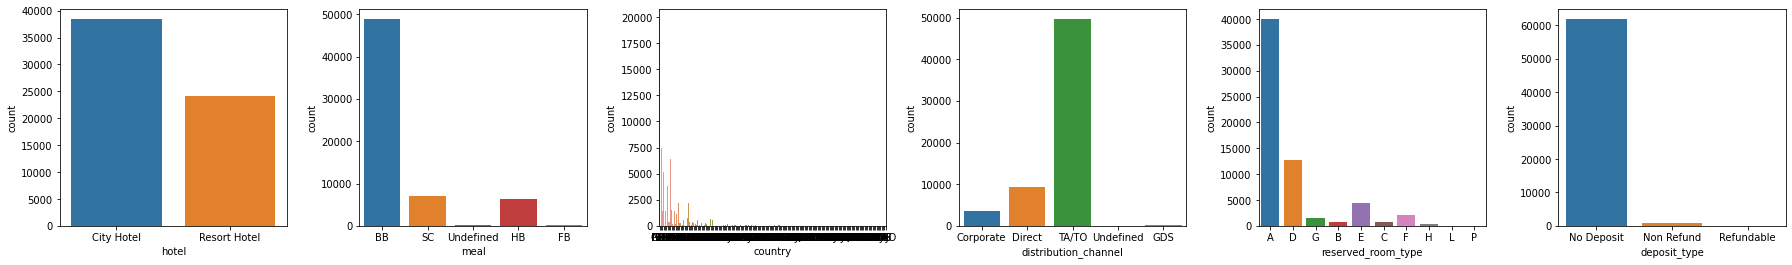

In [12]:
plt.figure(figsize=(25, 25))
for i in range(0, len(categorical)):
    plt.subplot(7, len(categorical), i+1)
    sns.countplot(Train[categorical[i]])
    plt.tight_layout()

### EDA for Numerical 

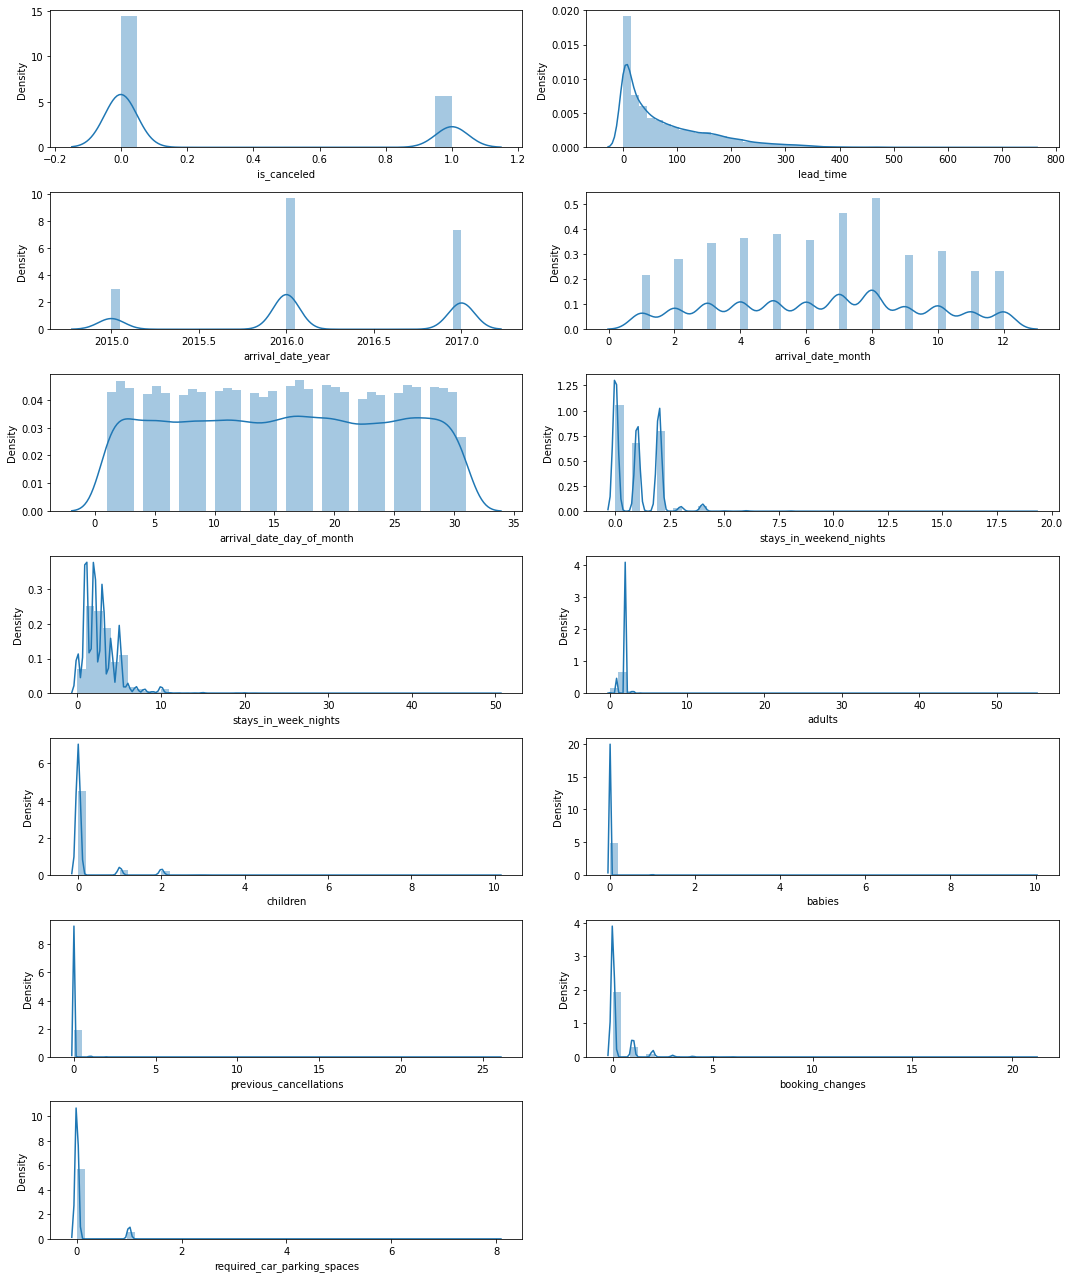

In [13]:
plt.figure(figsize=(15, 25))
for i in range(0, len(numerical)):
    plt.subplot(10, int(len(numerical)/5), i+1)
    sns.distplot(Train[numerical[i]])
    plt.tight_layout()

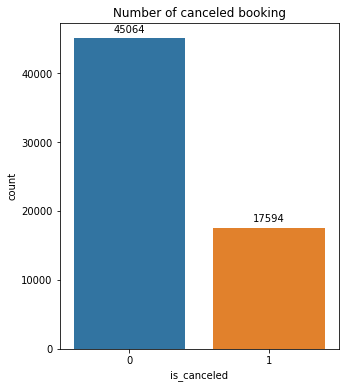

In [14]:
plt.figure(figsize=(5, 6))
cancel_ax = sns.countplot(Train['is_canceled'])

for p in cancel_ax.patches:
    cancel_ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title("Number of canceled booking")
plt.show()

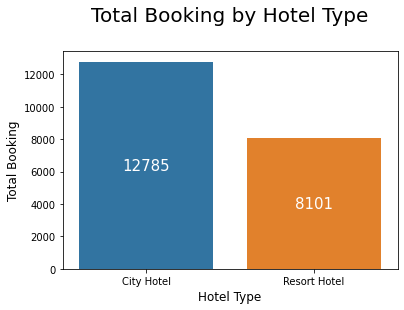

In [15]:
hotel_ax2 = sns.countplot(Test['hotel'])
for p in hotel_ax2.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    hotel_ax2.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=15)

plt.title('Total Booking by Hotel Type', fontsize=20, pad=30)    
plt.xlabel('Hotel Type', fontsize=12)
plt.ylabel('Total Booking', fontsize=12)
plt.show()

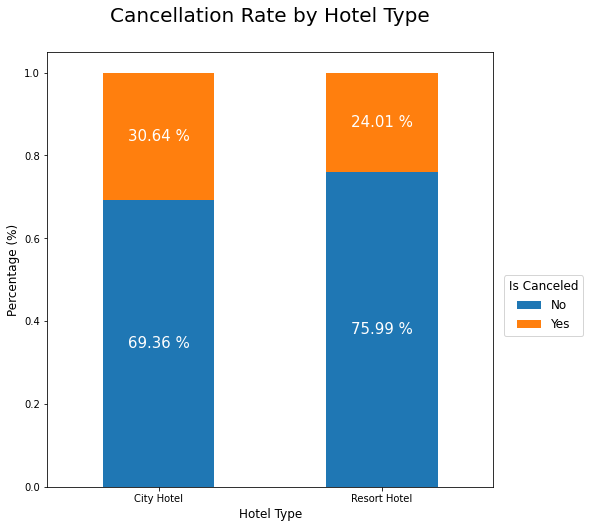

In [16]:
hotel_ax = pd.crosstab(Train['hotel'], Train['is_canceled'], normalize = 'index').plot.bar(stacked=True, figsize=(8,8))
plt.legend(bbox_to_anchor=(1.01, 0.5), title='Is Canceled', fontsize=12, title_fontsize=12, labels=['No','Yes'])
    
for p in hotel_ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    hotel_ax.text(x+width/2, 
            y+height/2, 
            '{:.2f} %'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white', fontsize=15)
    
plt.title('Cancellation Rate by Hotel Type', fontsize=20, pad=30)    
plt.xticks(rotation=360)
plt.xlabel('Hotel Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.show()

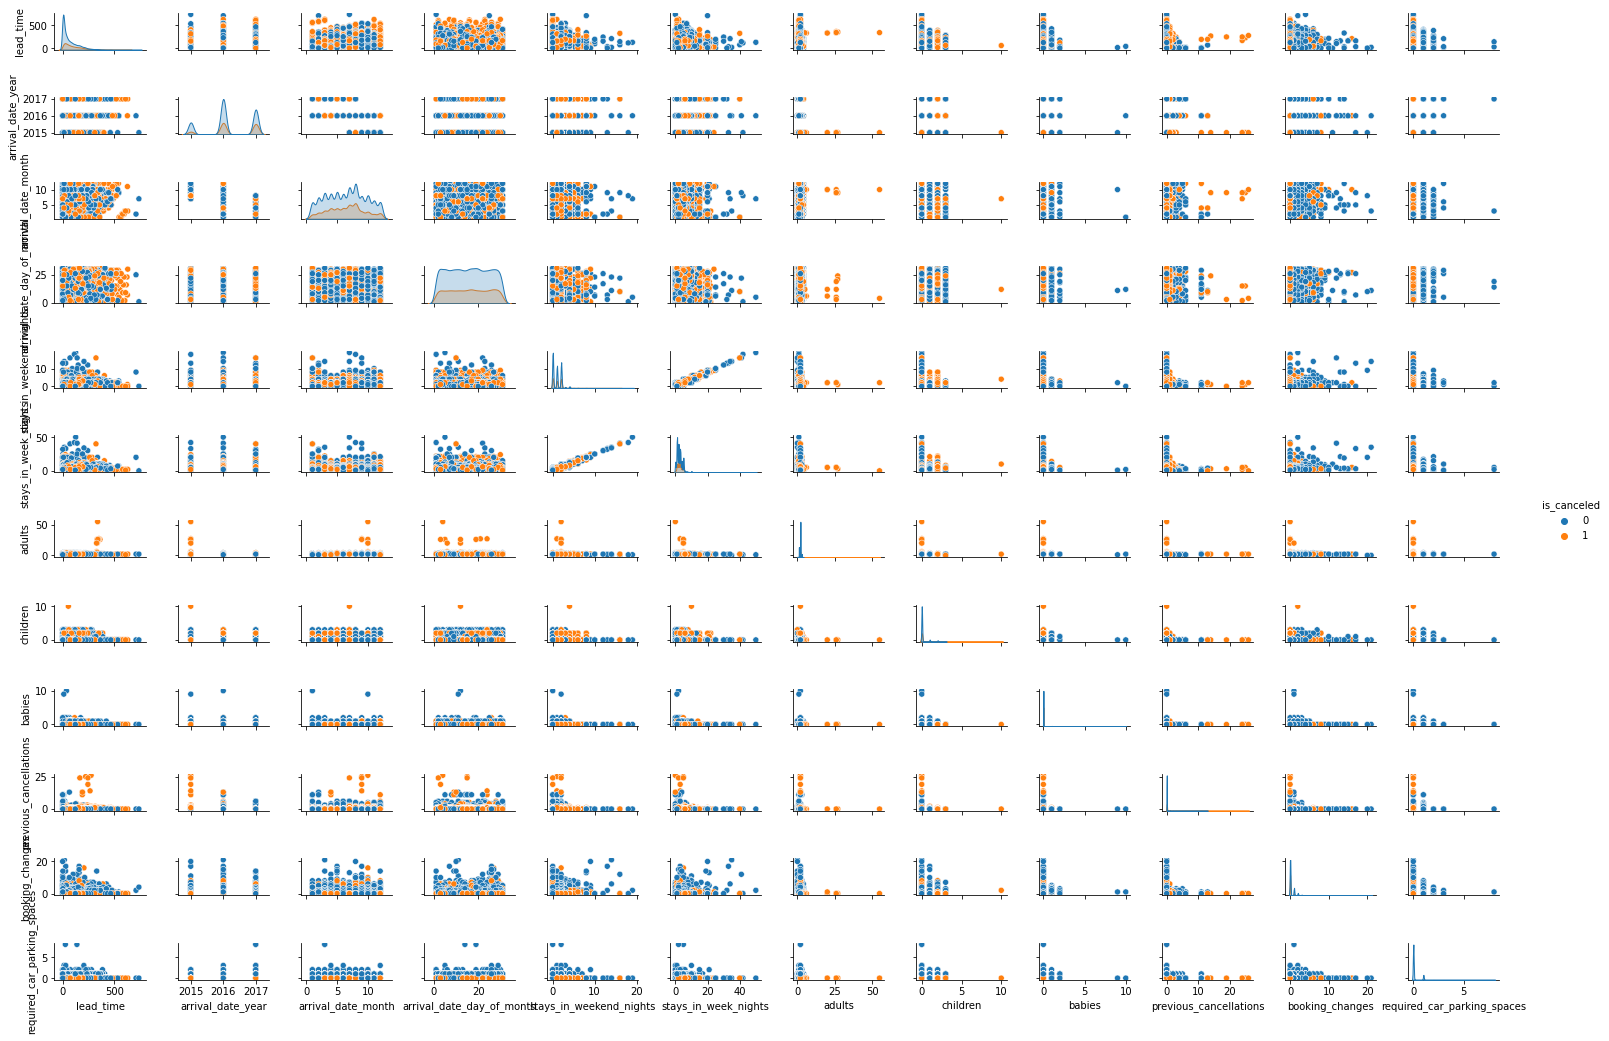

In [18]:
ax = sns.pairplot(Train, height=1.2, aspect=1.5,hue='is_canceled')

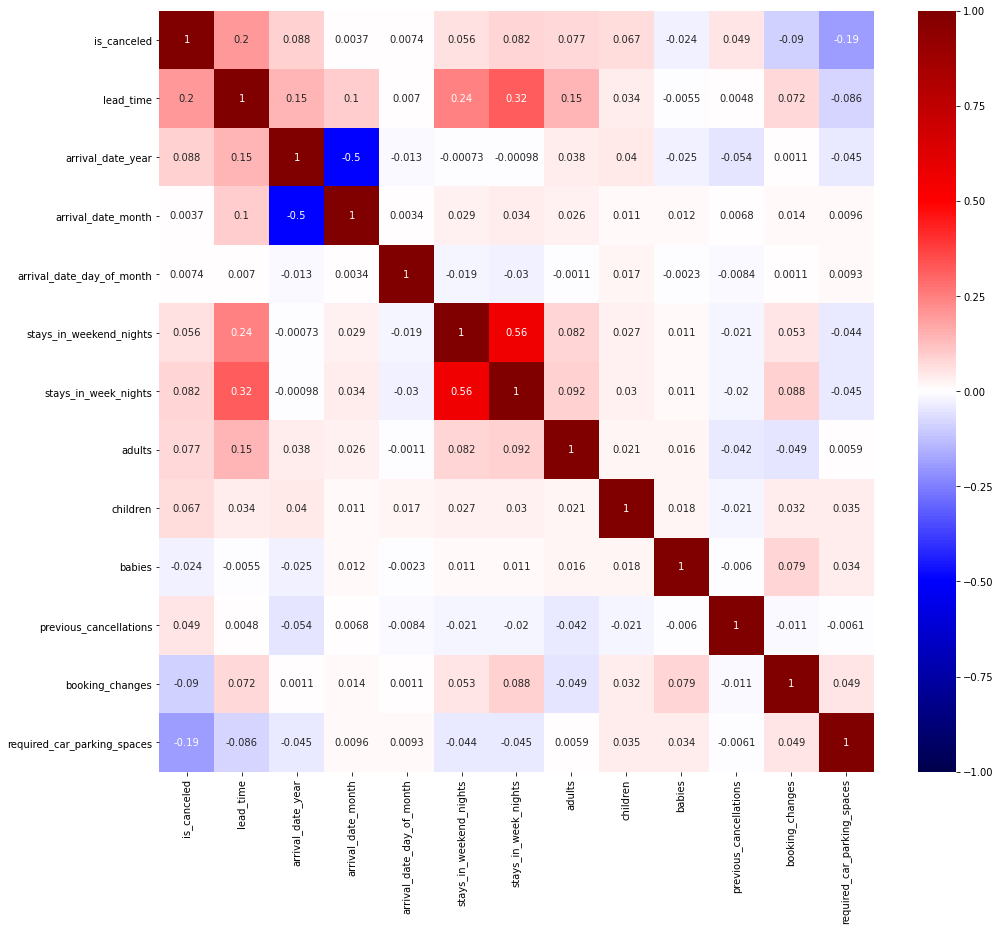

In [19]:
plt.figure(figsize=(16,14))
sns.heatmap(Train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
plt.show()

## Models

In [20]:
def LogisticClassfication(X_train,y_train,X_test,y_test):
    LR = LogisticRegression(max_iter = 1000, random_state = 42)
    LR.fit(X_train,y_train)
    
    print("Train Scores:")
    preds = LR.predict(X_train)
    mdl_score(y_train,preds)
    
    print("-----------------------------------------------")
    print("\nValidation scores:")
    preds_val = LR.predict(X_test)
    mdl_score(y_test,preds_val)
    
    show_cmatrix(y_test,preds_val)
    return LR

    
    
    
    
def DecisionTree(X_train,y_train,X_test,y_test):
    DT = DecisionTreeClassifier()
    DT.fit(X_train,y_train)
  
    print("Train Scores:")
    preds = DT.predict(X_train)
    mdl_score(y_train,preds)
    
    print("-----------------------------------------------")
    print("\nValidation scores:")
    preds_val = DT.predict(X_test)
    mdl_score(y_test,preds_val)
    return DT
    
    
    
    
def RandomForest(X_train,y_train,X_test,y_test):
    RF = RandomForestClassifier()
    RF.fit(X_train,y_train)
    
    print("Train Scores:")
    preds = RF.predict(X_train)
    mdl_score(y_train,preds)
    
    print("-----------------------------------------------")
    print("\nValidation scores:")
    preds_val = RF.predict(X_test)
    mdl_score(y_test,preds_val)
    return RF
    
    
def Boost(X_train,y_train,X_test,y_test):
    xg_model = XGBClassifier(verbosity = 0)
    xg_model.fit(X_train, y_train) 

    print("Train Scores:")
    preds = xg_model.predict(X_train)
    mdl_score(y_train,preds)
    
    print("-----------------------------------------------")
    print("\nValidation scores:")
    preds_val = xg_model.predict(X_test)
    mdl_score(y_test,preds_val)
    

    
def SVM(X_train,y_train,X_test,y_test):
    svm_clf = svm.SVC(kernel='linear')
    svm_clf.fit(X_train,y_train)
    
    print("Train Scores:")
    preds = svm_clf.predict(X_train)
    mdl_score(y_train,preds)
    
    print("-----------------------------------------------")
    print("\nValidation scores:")
    preds_val = svm_clf.predict(X_test)
    mdl_score(y_test,preds_val)
    return svm_clf



############## A function to score the model #################
def mdl_score(actual,preds, bta = 2): 
    print("The accuarcy score is",accuracy_score(actual, preds))
    print("The f1 score is",f1_score(actual, preds))
    print("The precision score is",precision_score(actual, preds))
    print("The recall score is",recall_score(actual, preds))
    f_bta = fbeta_score(actual, preds, beta=bta)
    print("The fbeta of", bta,"score is", f_bta)
    return f_bta


def show_cmatrix(ytest, pred):
    # Creating confusion matrix 
    cm = confusion_matrix(ytest, pred)

    # Putting the matrix a dataframe form  
    cm_df = pd.DataFrame(cm, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])
    
    # visualizing the confusion matrix
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
        
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df.columns, yticklabels=cm_df.index, annot_kws={"size": 20})
    plt.title("Confusion Matrix", size=20)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class');

### Baseline model

In [21]:
Trainbasse = Train.loc[:, (Train.dtypes == int) | (Train.dtypes == float)]
Testbasse = Test.loc[:, (Test.dtypes == int) | (Test.dtypes == float)]

Train Scores:
The accuarcy score is 0.7274569887324843
The f1 score is 0.19867673971188587
The precision score is 0.5695453322571966
The recall score is 0.1203251108332386
The fbeta of 2 score is 0.14286099901475172
-----------------------------------------------

Validation scores:
The accuarcy score is 0.7308244757253662
The f1 score is 0.1901469317199654
The precision score is 0.5674978503869303
The recall score is 0.11420661014016266
The fbeta of 2 score is 0.13591993080439885


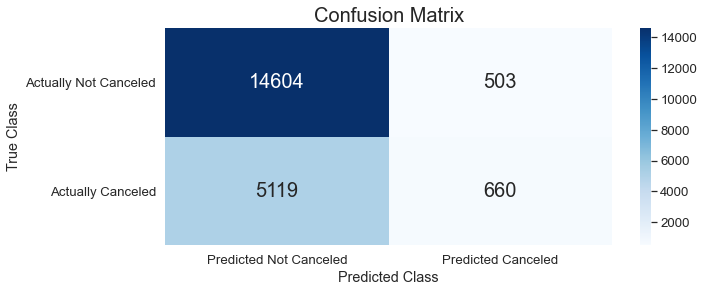

In [22]:
X_train=Trainbasse.drop('is_canceled', axis = 1)
y_train=Trainbasse.is_canceled

X_Test=Testbasse.drop('is_canceled', axis = 1)
y_Test=Testbasse.is_canceled

baseline=LogisticClassfication(X_train,y_train,X_Test,y_Test)